initial_error [0.00086413]


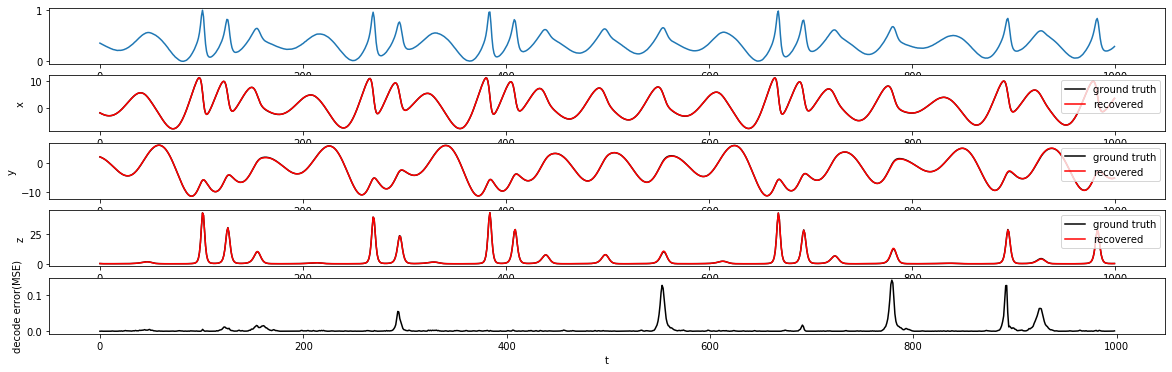

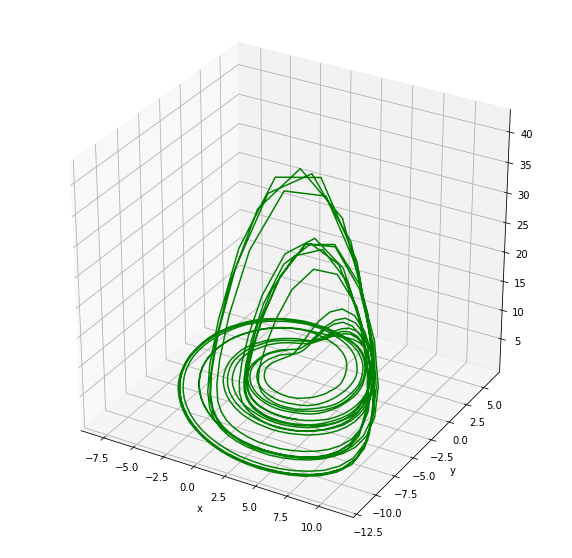

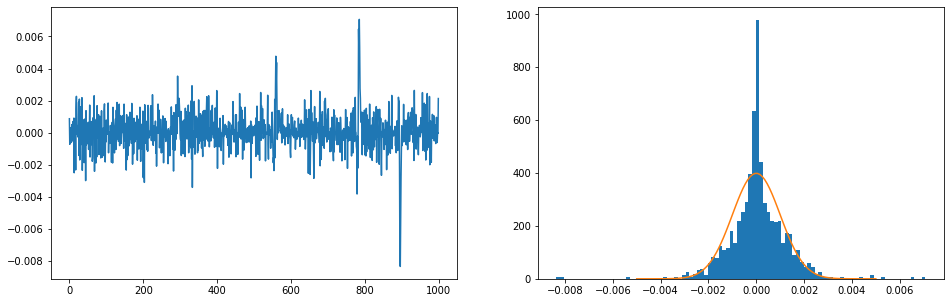

initial_error [0.00221774]


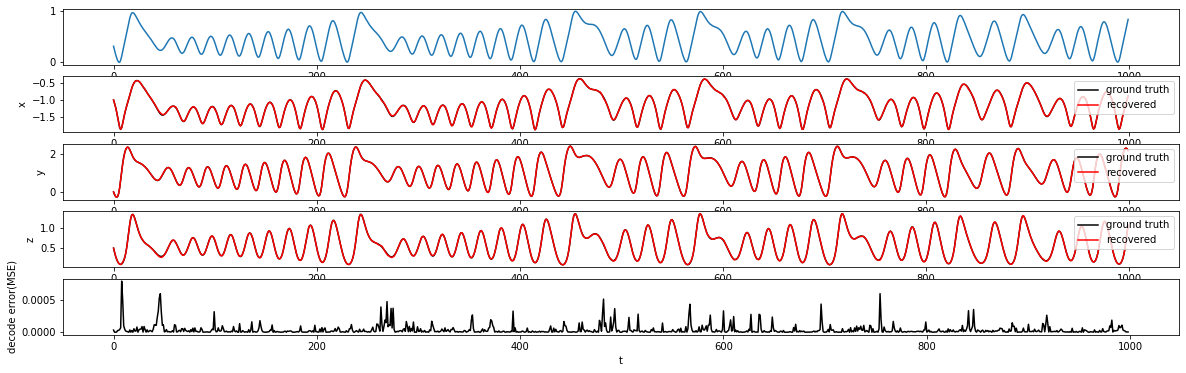

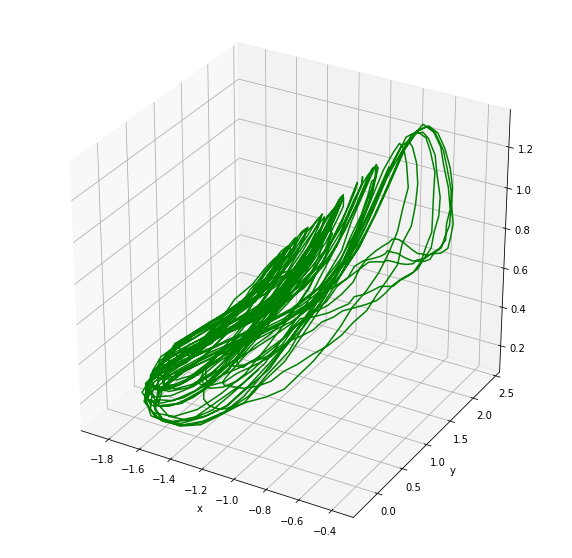

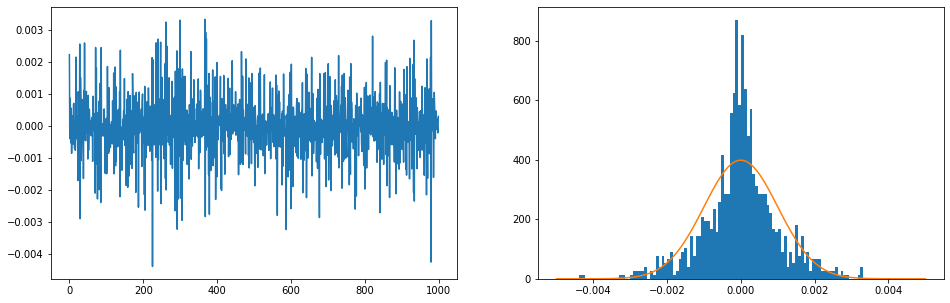

initial_error [0.00023175]


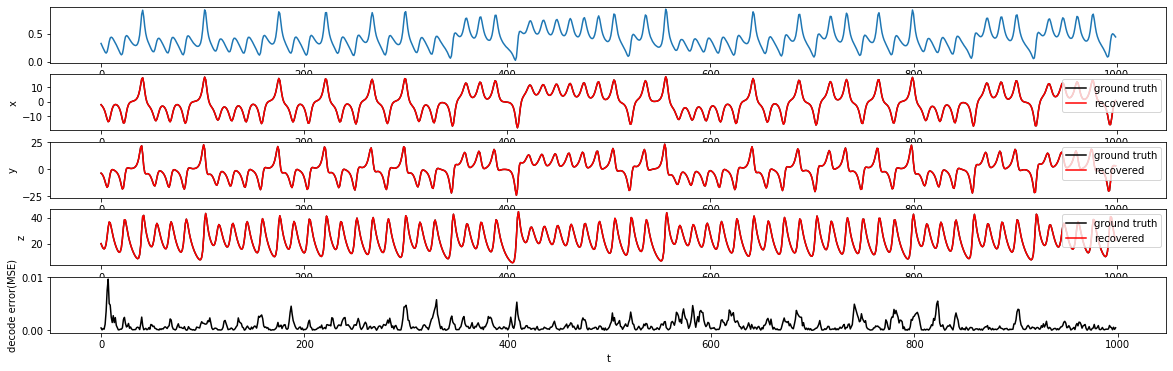

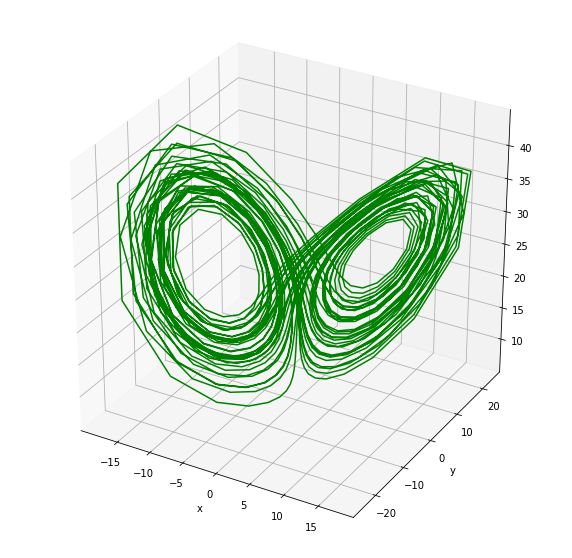

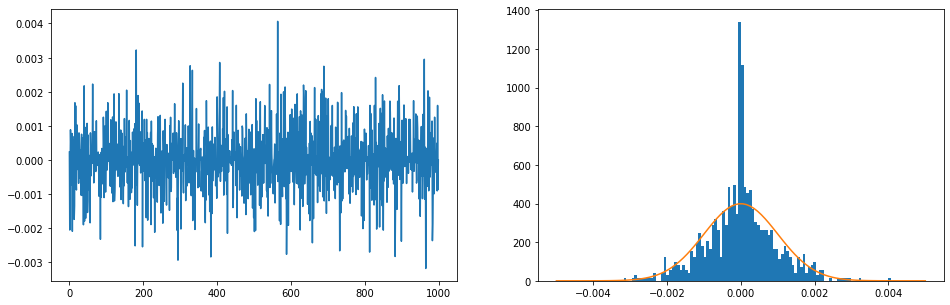

initial_error [0.00155156]


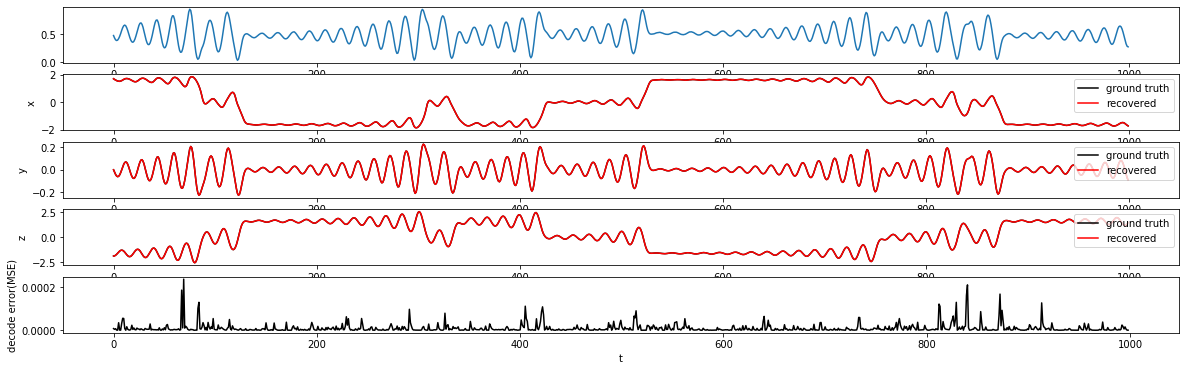

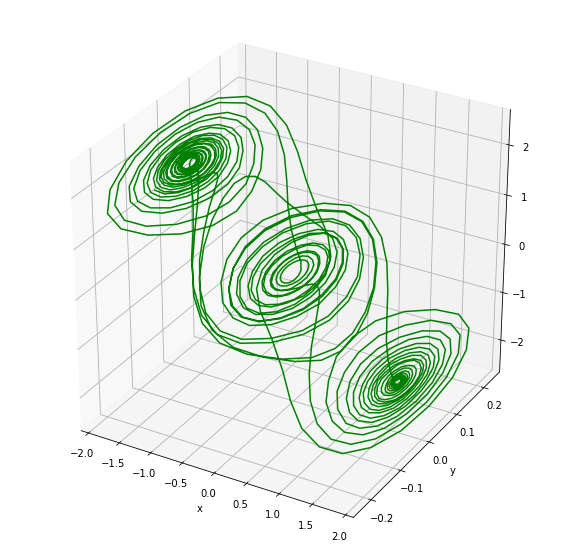

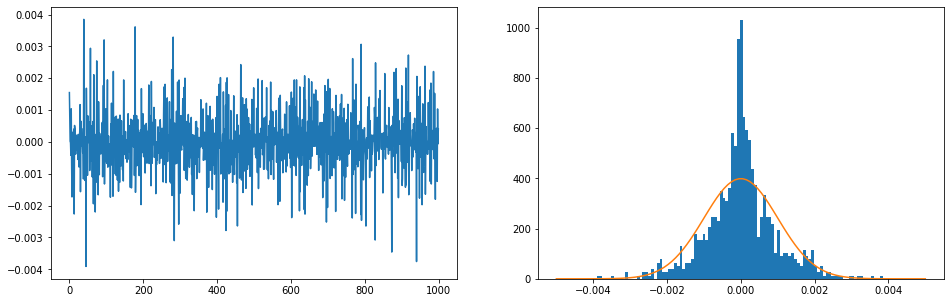

In [44]:
from dataset.chaotic_system import *
import numpy as np
from utils import *
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

path = 'result/particle filter'
if not os.path.exists(path):
    os.makedirs(path)

names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]


def show(x):
    x = np.atleast_2d(x)
    print(x.shape)
    plt.figure(figsize=(20, 6))
    dim = ['x', 'y', 'z']
    for i in range(x.shape[0]):
        plt.subplot(3, 1, i + 1)
        plt.plot(x[i, :].T, color='green', label='train set')
        plt.ylabel(dim[i])
        plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.show()


def show_3d(x, save=None):
    x = np.atleast_2d(x)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x[:3, :], 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(save)


def col_normalize(x, f):
    if x.shape[0] == 0:
        return x
    fx = f(x)
    fx_sum = fx.sum(axis=0).reshape([1, fx.shape[1]])
    return fx / fx_sum

def recover(x, row_min, row_max):
    return  x * (row_max - row_min) + row_min

def transform(x, row_min, row_max):
    return (x - row_min) / (row_max - row_min)

for system_name in names:
    x3d = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',')
    x1d = np.loadtxt('dataset/' + system_name + '1d.txt', delimiter=',')
    x1d += np.random.randn(*x1d.shape)*0.001
    
    scales = np.loadtxt('dataset/'+system_name+'_recover.txt', delimiter=',')
    C = np.array([[0.3, 0.3, 0.4]]).T

    test_start = 0  # test_start + horizon
    x3d = recover(x3d, scales[:3, 0], scales[:3,1])
    x_pred = np.zeros((len(x1d), 3))
    x_pred[0] = x3d[test_start]


    observations = transform(x_pred[0], scales[:3, 0], scales[:3, 1]).dot(C)
    observations = transform(observations, scales[-1, 0], scales[-1, 1])
    initial_error = np.abs(observations - x1d[0])
    print('initial_error',initial_error)


    functions, _, step_size = gen_model(system_name)

    N_particles = 1000
    radius = 1e-2
    h = 5
    particles = np.empty((N_particles, h+1, 3))
    N_decode = 1000
    decode_error = []

    for t in tqdm(range(1,N_decode)):
        center = x_pred[t-1]

        particles[:, 0] = center + [np.random.randn(*center.shape) * radius for _ in range(N_particles)]
        particles[0, 0] = center

        for i in range(N_particles):

            for hi in range(h):
                dX = dxdt(functions, particles[i,hi], np.nan, step_size)
                particles[i,hi+1] = particles[i,hi] + dX

        observations = particles.reshape((-1, 3))
        observations = transform(observations, scales[:3, 0], scales[:3,1]).dot(C)
        observations = transform(observations, scales[-1, 0], scales[-1, 1])
        observations = observations.reshape((N_particles, h+1))

        weights = -np.log(np.sum(np.abs(observations[:,] - x1d[t-1:t+h]),axis=1))

#         average = particles[:,1].T @ weights/np.sum(weights)
        best_choice = particles[np.argmax(weights)][1]

        decode_error.append(np.mean(np.square(best_choice - x3d[t+test_start])))
        x_pred[t] = best_choice


    plt.figure(figsize=(20, 6))
    dim = ['x', 'y', 'z']
    plt.subplot(5,1,1)
    plt.plot(x1d[test_start:test_start+N_decode])
    for i in range(3):
        plt.subplot(5, 1, i + 2)
        plt.plot(x3d.T[i, test_start:test_start+N_decode], color='black', label='ground truth')
        plt.plot(x_pred.T[i, :N_decode], color='red', label='recovered')
        plt.ylabel(dim[i])
        plt.legend(loc='upper right')
    plt.subplot(5, 1, 5)
    plt.plot(decode_error, color='black')
    plt.ylabel('decode error(MSE)')
    plt.xlabel('t')
    plt.savefig(path+'/' + system_name + '_1drecover.pdf')
    
    show_3d(x_pred[:N_decode].T, save = path+'/' + system_name + '_3drecover.pdf')

    expected = transform(x_pred, scales[:3, 0], scales[:3, 1]).dot(C)
    expected = transform(expected, scales[-1, 0], scales[-1, 1])
    recover_error = x1d - np.squeeze(expected.T)
    recover_error = recover_error[:N_decode]
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(recover_error)
    plt.subplot(1,2,2)
    _ = plt.hist(recover_error, bins=100, density=True)
    x = np.linspace(-0.005,0.005,100)
    sigma2 = 0.001**2
    y = np.exp(-0.5*x**2/sigma2)/np.sqrt(2*np.pi*sigma2)
    plt.plot(x,y)
    plt.savefig(path+'/' + system_name + '_1derror.pdf')
    
    plt.show()




In [49]:
from scipy import stats
import pandas as pd


df = pd.DataFrame(recover_error, columns =['value'])
u = df['value'].mean()  # 计算均值
std = df['value'].std()  # 计算标准差

stats.kstest(df['value'], 'norm', (0, 0.001))
# .kstest方法：KS检验，参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差
# 结果返回两个值：statistic → D值，pvalue → P值
# p值大于0.05，为正态分布

KstestResult(statistic=0.09138825384706328, pvalue=1.0193101642948041e-07)

In [50]:
help(stats.kstest)

Help on function kstest in module scipy.stats.stats:

kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='approx')
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    
    This performs a test of the distribution F(x) of an observed
    random variable against a given distribution G(x). Under the null
    hypothesis the two distributions are identical, F(x)=G(x). The
    alternative hypothesis can be either 'two-sided' (default), 'less'
    or 'greater'. The KS test is only valid for continuous distributions.
    
    Parameters
    ----------
    rvs : str, array or callable
        If a string, it should be the name of a distribution in `scipy.stats`.
        If an array, it should be a 1-D array of observations of random
        variables.
        If a callable, it should be a function to generate random variables;
        it is required to have a keyword argument `size`.
    cdf : str or callable
        If a string, it should be the name of a distribution i